# Introduction

The purpose of this project is to use data analysis and machine learning to make a study on employees data set regarding their absences.
## Objectives
1. Prepare the data by cleaning and add needed columns for analysis.
2. Apply statistical summaries to provide deeper understanding of the data.
3. Build a model that predict the employee absence behaviour based on other information.


## Turt Team 
 ---------
<big>
    <strong>Team Name: </strong>Turt <br>
    <strong>Project Leader: </strong> Ammar Almajed<br>
    <strong>Team Members:</strong>
</big>
 
|     Name   |
|:------------:|
|  Ammar Almajed 
|    Abdulmohsen Abanmy   
| Elyas Almubarak

## Setting Dataframe and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("AbsEmployees.csv")

# Data Processing
## Initial Data Info 

In [2]:
data.info()
data.describe()
display(data.describe()) # Show statstics before preparation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EmployeeNumber  8336 non-null   int64  
 1   Surname         8336 non-null   object 
 2   GivenName       8336 non-null   object 
 3   Gender          8336 non-null   object 
 4   JobTitle        8336 non-null   object 
 5   DepartmentName  8336 non-null   object 
 6   StoreLocation   8336 non-null   object 
 7   Division        8336 non-null   object 
 8   Age             8336 non-null   float64
 9   LengthService   8336 non-null   float64
 10  AbsentHours     8336 non-null   float64
 11  BusinessUnit    8336 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 781.6+ KB


,EmployeeNumber,Age,LengthService,AbsentHours
count,8336.000000,8336.000000,8336.000000,8336.000000
mean,4168.500000,42.007086,4.782910,61.283978
std,2406.540255,9.939798,2.462990,49.038365
min,1.000000,3.504743,0.012098,0.000000
25%,2084.750000,35.298748,3.575892,19.127590
50%,4168.500000,42.114924,4.600248,56.005808
75%,6252.250000,48.666943,5.623922,94.284692
max,8336.000000,77.938003,43.735239,272.530123


## Data Preparation

In [3]:
def prepare_data(df):
    df = df.copy()
    
    ## Making Columns
    # Average Absence per year
    df['AbsentPerYear'] = df['AbsentHours'] / df['LengthService']

    ## Editing Columns
    # Rounding Float Numbers
    df["Age"] = df["Age"].apply(lambda x: round(x, 2))
    df["LengthService"] = df["LengthService"].apply(lambda x: round(x, 2))
    df["AbsentHours"] = df["AbsentHours"].apply(lambda x: round(x, 2))
    df["AbsentPerYear"] = df["AbsentPerYear"].apply(lambda x: round(x, 2))
    
    ## Dropping useless Columns
    # BusinessUnit because it is a duplicate of Division with less information
    df = df.drop(columns = ['EmployeeNumber', 'Surname', 'GivenName', 'AbsentHours', 'BusinessUnit'])
    
    # dropping unsence data 
    df = df.drop(index=df[(df['Age'] < 18) | (abs(df['Age'] - df['LengthService']) < 18)].index)
    
    # Removing outliers
    z_scores = np.abs((df['AbsentPerYear'] - df['AbsentPerYear'].mean()) / df['AbsentPerYear'].std())
    df = df.loc[z_scores <= 3]

    # Creating another column that grade the employee on scale from 1 to 5 based on their absences (1 very bad and 5 is very good)
    def absentGrade(absent, grade_map):
      if absent <= grade_map[5]:
          return 5
      elif absent <= grade_map[4]:
          return 4
      elif absent <= grade_map[3]:
          return 3
      elif absent <= grade_map[2]:
          return 2
      else:
          return 1
        
        

    max_absent = np.max(df['AbsentPerYear'])

    grade_map = {5: max_absent * 0.20, 4: max_absent * 0.40, 3: max_absent * 0.60, 2: max_absent * 0.80, 1: max_absent}

    df['Grade'] = df['AbsentPerYear'].apply(lambda x: absentGrade(x, grade_map))

  
    
    return df

## Data Processing for Model Usage

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def one_hot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column])
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    
    return df

def process_data(df, classification = False):
    ndf = df.copy()
    for col in df:
        if df[col].dtype == 'object':
            ndf = one_hot_encode(ndf, col)
    if classification:
      col = 'Grade'
    else:
      col = 'AbsentPerYear'
    y = ndf[col].values
    X = ndf.drop(columns = ['AbsentPerYear', 'Grade']).values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
    return X_train, X_test, y_train, y_test

## Data Info After Preparation

In [5]:
df = prepare_data(data) 
display(df) 

,Gender,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentPerYear,Grade
0,F,Baker,Bakery,Burnaby,Stores,32.03,6.02,6.08,5
1,M,Baker,Bakery,Nanaimo,Stores,40.32,5.53,5.45,5
2,M,Baker,Bakery,Richmond,Stores,48.82,4.39,19.09,5
3,F,Baker,Bakery,Victoria,Stores,44.60,3.08,22.72,4
4,M,Baker,Bakery,New Westminster,Stores,35.70,3.62,0.00,5
...,...,...,...,...,...,...,...,...,...
8331,F,Cashier,Customer Service,Langley,Stores,46.06,4.84,19.36,5
8332,M,Cashier,Customer Service,Fort St John,Stores,34.46,2.43,0.00,5
8333,F,Cashier,Customer Service,West Vancouver,Stores,58.35,4.01,43.99,3
8334,F,Dairy Person,Dairy,Vancouver,Stores,43.34,6.15,9.80,5


In [6]:
df.info()
display(df.describe()) # Show statstics after preparation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8070 entries, 0 to 8335
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          8070 non-null   object 
 1   JobTitle        8070 non-null   object 
 2   DepartmentName  8070 non-null   object 
 3   StoreLocation   8070 non-null   object 
 4   Division        8070 non-null   object 
 5   Age             8070 non-null   float64
 6   LengthService   8070 non-null   float64
 7   AbsentPerYear   8070 non-null   float64
 8   Grade           8070 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 630.5+ KB


,Age,LengthService,AbsentPerYear,Grade
count,8070.000000,8070.000000,8070.000000,8070.000000
mean,42.629924,4.786173,15.494133,4.654647
std,9.254378,2.453698,14.669787,0.644384
min,19.200000,0.280000,0.000000,1.000000
25%,35.890000,3.580000,4.740000,4.000000
50%,42.435000,4.600000,12.510000,5.000000
75%,48.810000,5.610000,21.977500,5.000000
max,77.940000,43.740000,104.710000,5.000000


# Visualization & Statistical Summaries

## General Summaries 
### Correlations for numerical columns

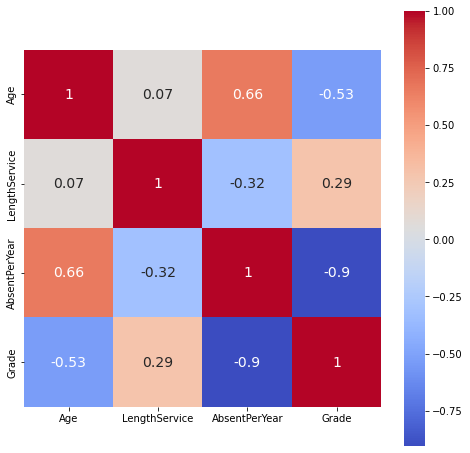

In [7]:
# Creating a heat map and setting the data to be corrleations of the dataframe
plt.figure(figsize=(8,8))# Setting size
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, square=True,annot_kws={"size": 14})
plt.show();

- Age and Length of service have very weak correlation that could be a sign that we don't have many people working for long time with the company
- Age and absents per year have strong correlation indicating that the older people might have higher average of absents.
- Length of service and absents per year have negative correlation and it could be a sign that people with higher length service has lower average of absents.

### Absents Data Distribution

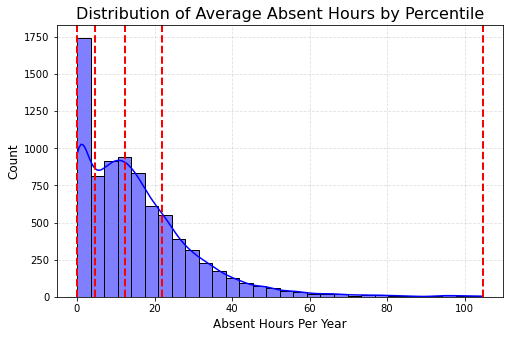

Data Statstics:


,count,mean,std,min,25%,50%,75%,max,0 count
AbsentPerYear,8070.0,15.494133,14.669787,0.0,4.74,12.51,21.9775,104.71,1099


In [21]:
# Setting percentiles
percentiles = np.percentile(df['AbsentPerYear'], [0, 25, 50, 75, 100])
plt.figure(figsize=(8,5))#setting size

# Plot histogram
sns.histplot(df['AbsentPerYear'],bins=30, alpha=0.5, color='blue',kde = True)

# Add vertical lines for percentiles
for p in percentiles:
    plt.axvline(x=p, color='red', linestyle='--', linewidth=2)
    
# Gridlines
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Set title and axis labels
plt.title('Distribution of Average Absent Hours by Percentile', fontsize=16)
plt.xlabel('Absent Hours Per Year',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.show()

# Describe absents per year statstics indside a table
print('Data Statstics:')
summary= pd.DataFrame(df['AbsentPerYear'].describe()).T
summary['0 count']=(df["AbsentPerYear"] == 0).sum()
display(summary)

 - The median is 12.51 Hours per year and mean is 14.49.
 - The standard deviation is 14.66 which is relatively high meaning that employees has obvious differences in term of attendance.
 - It's a positive skew distribution giving us that most employees are having good attendance.
 - We have 1099 employees that have 0 absents per year.
## Studies Based on Categories
### Studies Based on Genders

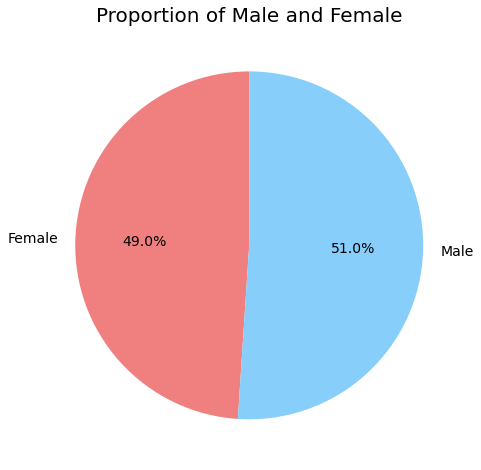

In [9]:
plt.figure(figsize=(8,8))#setting size
# Split the data frame based on gender.
df_female = df[df['Gender'] == 'F']
df_male = df[df['Gender'] == 'M']

# Count the number of females and males
count_male = len(df_male)
count_female = len(df_female)

# Setting a pie chart
labels = ['Female', 'Male']
proportion = [count_female, count_male]
colors = ['lightcoral', 'lightskyblue']
plt.pie(proportion, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Proportion of Male and Female',fontsize=20)
plt.show()

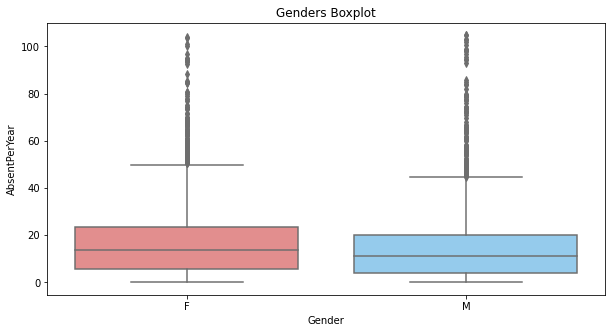

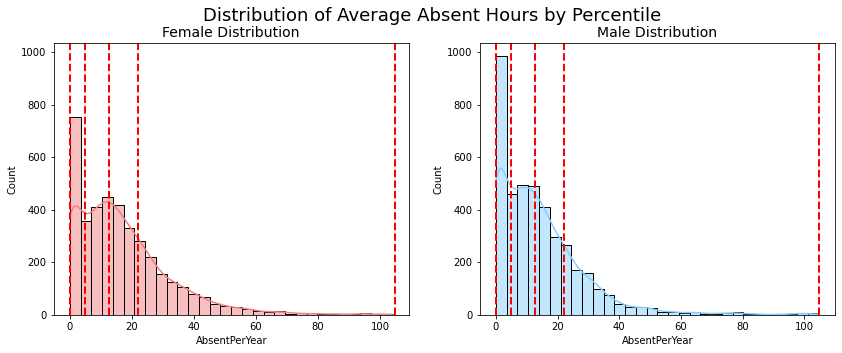

,count,mean,std,min,25%,50%,75%,max,0 count
Female,3951.0,16.861169,15.066255,0.0,5.845,13.94,23.6700,104.05,474
Male,4119.0,14.182853,14.157458,0.0,3.835,11.31,20.1800,104.71,625
Total,8070.0,15.494133,14.669787,0.0,4.740,12.51,21.9775,104.71,1099


In [10]:
# Setting a boxplot based on gender
plt.figure(figsize=(10,5))#setting size
sns.boxplot(data=df, x = 'Gender', y = 'AbsentPerYear', palette=['lightcoral', 'lightskyblue'])
plt.title('Genders Boxplot')
plt.show()


# Setting two subplots for genders absents distribution.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
sns.histplot(df_female['AbsentPerYear'],bins=30, alpha=0.5, color='lightcoral',kde = True,ax=ax1)
sns.histplot(df_male['AbsentPerYear'],bins=30, alpha=0.5, color='lightskyblue',kde = True,ax=ax2)

# Add vertical lines for percentiles
for p in percentiles:
    ax1.axvline(x=p, color='red', linestyle='--', linewidth=2)
    ax2.axvline(x=p, color='red', linestyle='--', linewidth=2)

# Giving them same y limit.
ylim_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim([0, ylim_max])
ax2.set_ylim([0, ylim_max])
fig.suptitle('Distribution of Average Absent Hours by Percentile', fontsize=18)
ax1.set_title('Female Distribution',fontsize=14)
ax2.set_title('Male Distribution',fontsize=14)

plt.show()
# Describe absents per year statstics for both genders indside a table 
# Summary for Female
summary_female = pd.DataFrame(df_female['AbsentPerYear'].describe()).T
summary_female['0 count'] = (df_female["AbsentPerYear"] == 0).sum()
summary_female.index = ['Female']
# Summary for Male
summary_male = pd.DataFrame(df_male['AbsentPerYear'].describe()).T
summary_male['0 count'] = (df_male["AbsentPerYear"] == 0).sum()
summary_male.index = ['Male']
# Summary for both Female and Male
total_summary= pd.DataFrame(df['AbsentPerYear'].describe()).T
total_summary['0 count']=(df["AbsentPerYear"] == 0).sum()
total_summary.index=['Total']
# Concat to display all in one table
summary_table = pd.concat([summary_female, summary_male,total_summary])
display(summary_table)

- Number of employees on both genders is almost equal. With <strong>51% Males</strong> and <strong>49% Females</strong>
- Female employees are having higher mean and median than male employees.
- Standard deviation is high on both genders. The females' standard deviation is slightly higher than the males' meaning that the performance differ more among them.
- Both genders have positive skew distribution meaning most employees on both genders have good attendance.
- Male employees have 151 more employees that have 0 absent hours.

###  Studies Based on Age and Service length

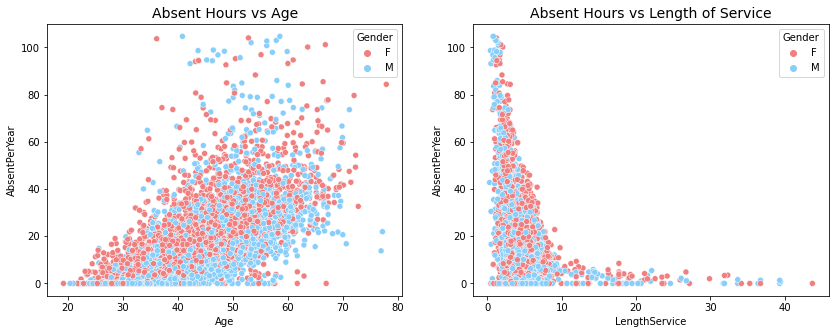

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))

# Setting a scatter plot for Absent Hours vs Age with using genders for hue.
sns.scatterplot(x='Age', y='AbsentPerYear', data=df, hue='Gender', palette=['lightcoral', 'lightskyblue'], ax=ax1)
ax1.set_title('Absent Hours vs Age',fontsize=14)

# Setting a scatter plot for Absent Hours vs Length of Service with using genders for hue.
sns.scatterplot(x='LengthService', y='AbsentPerYear', data=df, hue='Gender', palette=['lightcoral', 'lightskyblue'], ax=ax2)
ax2.set_title('Absent Hours vs Length of Service',fontsize=14)

plt.show()

- We can observe from the <strong> Absent Hours vs length of Service Plot </strong> that employees with longer length of service have low absents per year
### Studies Based on Job Titles and Locations

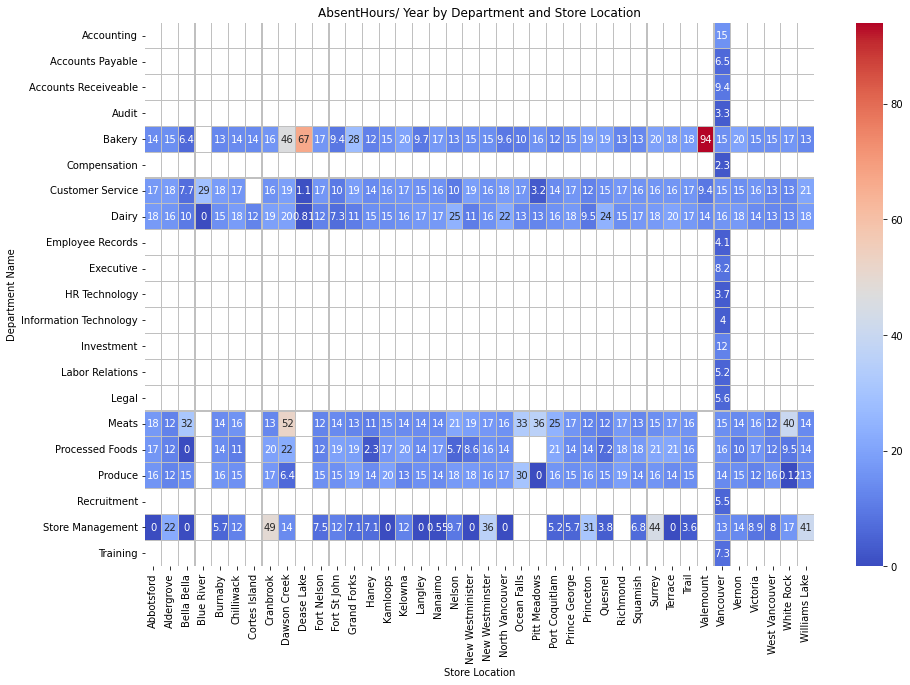

In [12]:
# Pivot table that gives the average AbsentPerYear  for each StoreLocation and DepartmentName combination
dept_store_absent_hours = pd.pivot_table(df, values='AbsentPerYear', index='DepartmentName', columns='StoreLocation')
# Setting a heatmap using pivot table
plt.figure(figsize=(15, 10))
sns.heatmap(dept_store_absent_hours, cmap='coolwarm', linewidths=.1, linecolor='silver',annot=True, facecolor='grey')
plt.title('AbsentHours/ Year by Department and Store Location')
plt.xlabel('Store Location')
plt.ylabel('Department Name')
plt.show()

- The bakery department seems to have a higher AbsentPerYear with 94 hours/year in Valemount(max across all), 67 hours/year in Dease Lake ,and 46 hours/year in Dawson Creek. 
- The Departments Customer Service, Dairy, Processed Foods and Produce have good performance across all cities.
- The Departments Meats and Store Management are having some issues in some locations.
- The Departments that locates only in Vancouver are having very good performance.

# Model Building 

### We have decided to build two models

first model `Regression Model` is to predect the `AbsentPerYear` column and the second model `Classification Model` is to classify the employee into one of the following grades 1 to 5 based on his absences where 1 is bad and 5 is good (basicly predict the value of grade column)

## Regression Model

In [13]:
X_train, X_test, y_train, y_test = process_data(prepare_data(data))


In [14]:
from sklearn.neural_network import MLPRegressor 

model = MLPRegressor()
model.fit(X_train, y_train)
print('Accuracy: %.2f' % round(model.score(X_test, y_test) * 100, 2) + "%")

Accuracy: 77.96%


C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


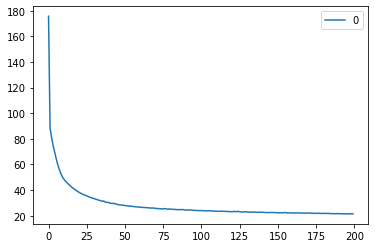

In [15]:
pd.DataFrame(model.loss_curve_).plot()

##Classification Model

Epoch 1/50
177/177 [==============================] - 2s 4ms/step - loss: 0.8439 - val_loss: 0.5373
Epoch 2/50
177/177 [==============================] - 1s 3ms/step - loss: 0.4438 - val_loss: 0.3725
Epoch 3/50
177/177 [==============================] - 1s 3ms/step - loss: 0.3822 - val_loss: 0.3872
Epoch 4/50
177/177 [==============================] - 1s 4ms/step - loss: 0.3822 - val_loss: 0.3750
Epoch 5/50
177/177 [==============================] - 1s 4ms/step - loss: 0.3611 - val_loss: 0.3888
Epoch 6/50
177/177 [==============================] - 1s 3ms/step - loss: 0.3718 - val_loss: 0.4165
Epoch 7/50
177/177 [==============================] - 1s 3ms/step - loss: 0.3564 - val_loss: 0.3778
Epoch 8/50
177/177 [==============================] - 1s 3ms/step - loss: 0.3651 - val_loss: 0.3498
Epoch 9/50
177/177 [==============================] - 0s 2ms/step - loss: 0.3548 - val_loss: 0.3659
Epoch 10/50
177/177 [==============================] - 0s 3ms/step - loss: 0.3536 - val_loss: 0.3766

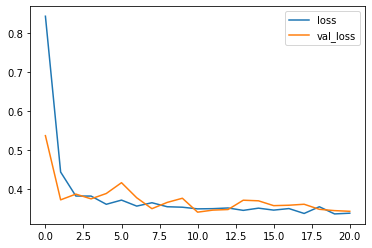

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping # This library is used to stop the training if it start to overfit

early_stop = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 10)

X_train, X_test, y_train, y_test = process_data(prepare_data(data), True)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values


# # Nerual Network for training our model 

model = Sequential()

model.add(Dense(120, activation = 'relu'))
model.add(Dense(60, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(15, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

# Training the model
model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), epochs = 50, callbacks = [early_stop])


# # Plotting the loss graph

losses = pd.DataFrame(model.history.history)
losses.plot()





In [17]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)

# printing the confusion matrix
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1)))

print(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1)))


76/76 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.60      0.46      0.52        13
           1       0.20      0.11      0.14        18
           2       0.53      0.57      0.55        92
           3       0.69      0.65      0.67       541
           4       0.91      0.93      0.92      1757

    accuracy                           0.84      2421
   macro avg       0.59      0.54      0.56      2421
weighted avg       0.84      0.84      0.84      2421

[[   6    3    4    0    0]
 [   3    2   11    2    0]
 [   1    3   52   35    1]
 [   0    2   26  353  160]
 [   0    0    5  121 1631]]


In [18]:
# Testing the model
CM = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1))

trace = np.trace(CM)
accuracy = trace / np.sum(CM)
print('Accuracy: ' + str(round(accuracy * 100, 2)) + "%")



Accuracy: 84.43%


# Conclusion

Based on our two models we got ≅ `78.40%` on the regression model and ≅ `83%` on the classification model.